# Trabajo Práctico 4

# Imports y función de entrenamiento

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento.
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    best_red = red
    best_red_error = 1.0
    error_train = []
    error_val = []
    error_test = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_val = red.predict(X_val)
      red_error_val = error_fun(y_val, P_val)
      error_val.append(red_error_val)

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      if red_error_val < best_red_error:
        best_red = copy.deepcopy(red)
        best_red_error = red_error_val

    return best_red, error_train, error_val, error_test

In [4]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [5]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

In [6]:
def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  count0 = 0
  count1 = 0
  l = []
  while (count0 + count1) < n:
    x = np.random.uniform(-1, 1, 1)
    y = np.random.uniform(-1, 1, 1)
    if ((x**2 + y**2)**0.5 < 1): # si esta adentro del circulo
      if (is_inside_curves(x, y)):
        if count0 < int(n/2):
          l.append([x, y, 0])
          count0+=1
      else:
        if count1 < int(n/2):
          l.append([x, y, 1])
          count1+=1
  df = pd.DataFrame(l, columns=['dim_1', 'dim_2', 'class'])
  return df

In [7]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

# Ejercicio A

## Valores generales

In [45]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

## Entrenamiento

### Diagonales

In [46]:
errors_diagonales_trees = {}
errors_diagonales_redes = {}
errors_diagonales_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

  errors_diagonales_redes[d] = errors_list_redes
  errors_diagonales_trees[d] = errors_list_trees
  errors_diagonales_naive_bayes[d] = errors_list_naive_bayes

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [47]:
errors_test_diagonales_tree_avg = []
errors_train_diagonales_tree_avg = []
for k, l in errors_diagonales_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_tree_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_tree_avg.append(sum_train/count_for_avg)

errors_test_diagonales_red_avg = []
errors_train_diagonales_red_avg = []
for k, l in errors_diagonales_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_red_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_red_avg.append(sum_train/count_for_avg)

errors_test_diagonales_naive_bayes_avg = []
errors_train_diagonales_naive_bayes_avg = []
for k, l in errors_diagonales_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_naive_bayes_avg.append(sum_train/count_for_avg)

### Paralelas

In [48]:
errors_paralelas_redes = {}
errors_paralelas_trees = {}
errors_paralelas_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})
  
  errors_paralelas_redes[d] = errors_list_redes
  errors_paralelas_trees[d] = errors_list_trees
  errors_paralelas_naive_bayes[d] = errors_list_naive_bayes

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [49]:
errors_test_paralelas_tree_avg = []
errors_train_paralelas_tree_avg = []
for k, l in errors_paralelas_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_tree_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_tree_avg.append(sum_train/count_for_avg)

errors_test_paralelas_red_avg = []
errors_train_paralelas_red_avg = []
for k, l in errors_paralelas_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_red_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_red_avg.append(sum_train/count_for_avg)

errors_test_paralelas_naive_bayes_avg = []
errors_train_paralelas_naive_bayes_avg = []
for k, l in errors_paralelas_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_naive_bayes_avg.append(sum_train/count_for_avg)

## Gráficas

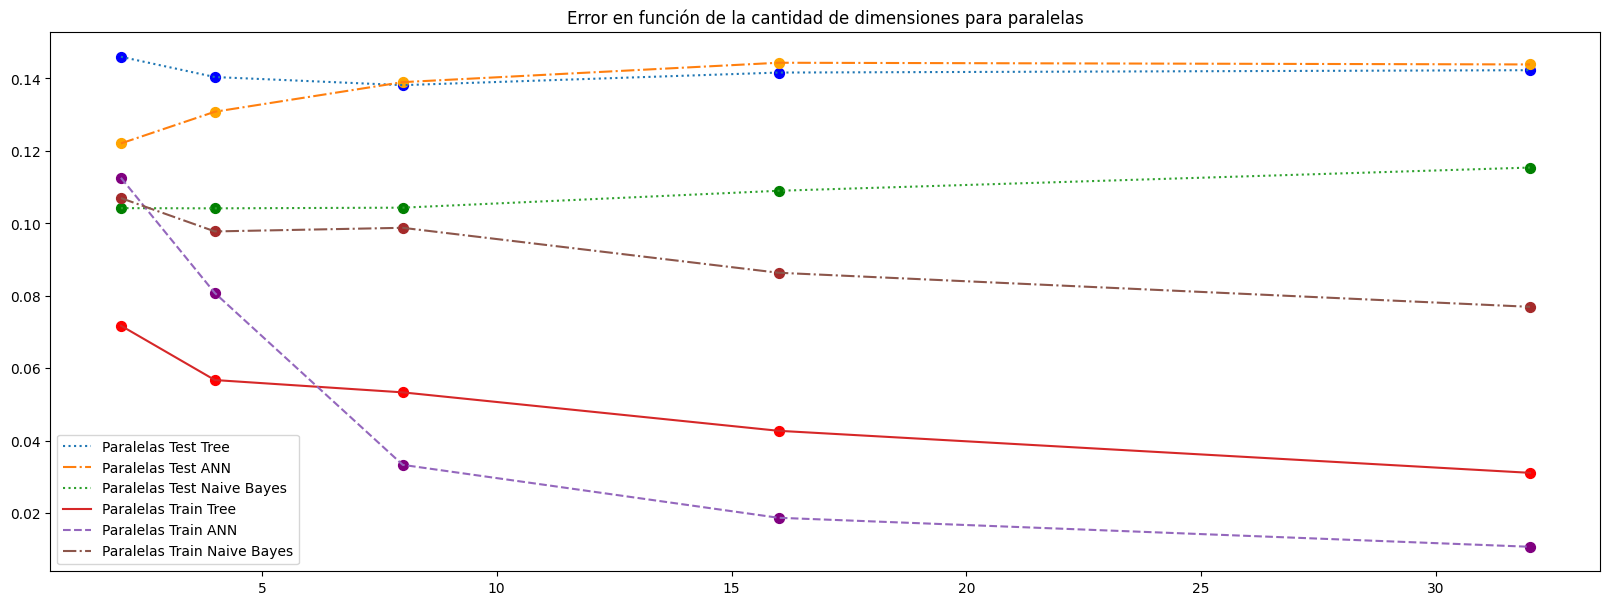

In [50]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

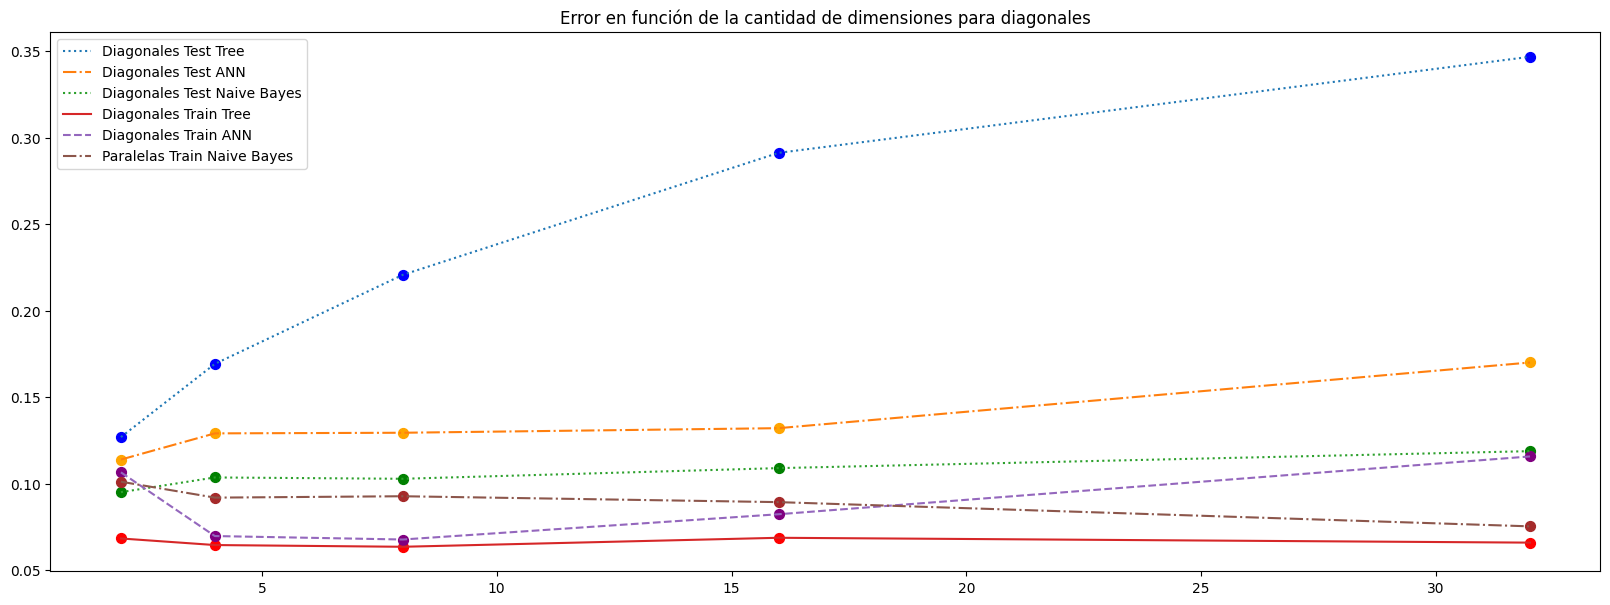

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Diagonales Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para diagonales')
plt.legend()
plt.show()

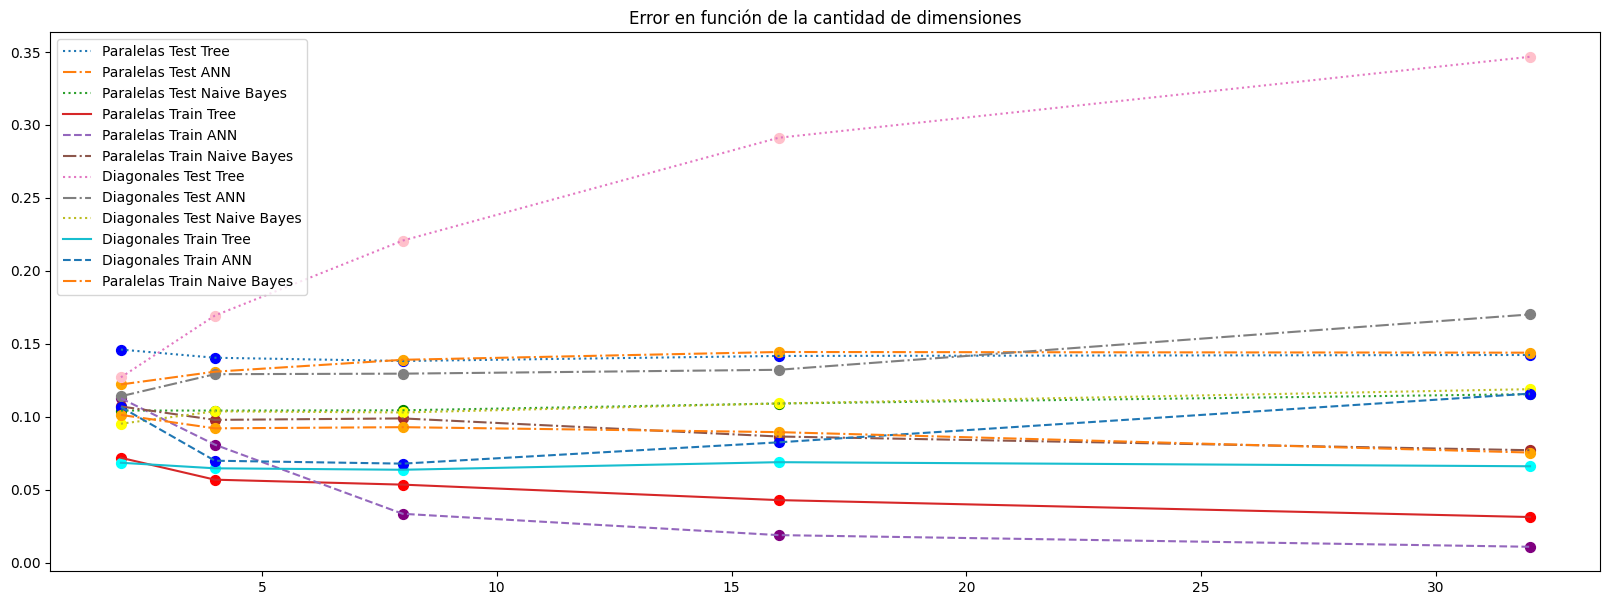

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50) 
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  
plt.scatter(d_values, errors_test_diagonales_tree_avg, color='pink', s=50)
plt.scatter(d_values, errors_test_diagonales_red_avg, color='grey', s=50)  
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='yellow', s=50)
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='cyan', s=50)
plt.scatter(d_values, errors_train_diagonales_red_avg, color='blue', s=50)
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='orange', s=50)

plt.title(f'Error en función de la cantidad de dimensiones')
plt.legend()
plt.show()

## Análisis

Podemos ver que el Naive Bayes obtiene mejores errores que las redes y que los arboles en ambos problemas, esto se debe a que el clasificador que estamos usando es el GaussianNB el cual es bueno para predecir distribuciones gaussianas, lo cual lo hace ideal para este problema obteniendo asi el mínimo error.

En ambos problemas podemos observar un overfitting cuando aumentan las dimensiones debido al vaciamiento del espacio, por lo que este método es afectado por la dimensionalidad. De todas maneras es menos notorio con respecto al resto de métodos.

# Ejercicio B

## Dos elipses

### Entrenamiento

In [50]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [51]:
#defino parámetros de la red
epocas_por_entrenamiento = 50     #numero de epocas que entrena cada vez
evaluaciones = 300
N2 = 6

alfa = 0.9
lr = 0.01
trys = 10

In [52]:
best_red = None
best_error = 1.0
for i in range(trys):
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    red, _, _, _ = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
    
    P_test = red.predict(X_test)
    test_error = zero_one_loss(y_test, P_test)

    if test_error < best_error:
        best_error = test_error
        best_red = red

In [53]:
# Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_data, y_data)

GaussianNB()

### Gráficas

Error de ANN fue 0.015000000000000013


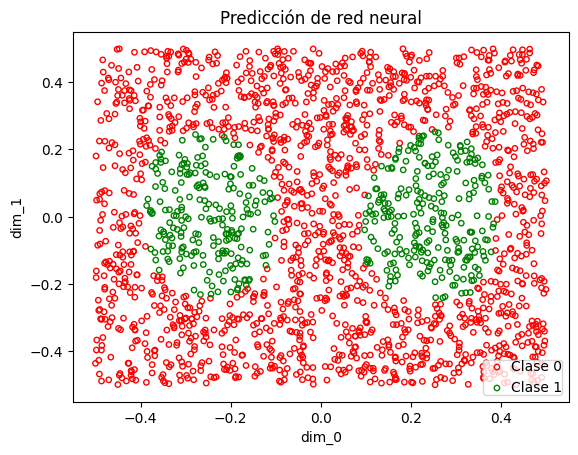

In [55]:
print(f"Error de ANN fue {best_error}")

prediction = best_red.predict(X_test)
idx = np.where(prediction == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de red neural')
plt.show()

Error de Naive Bayes fue 0.24350000000000005


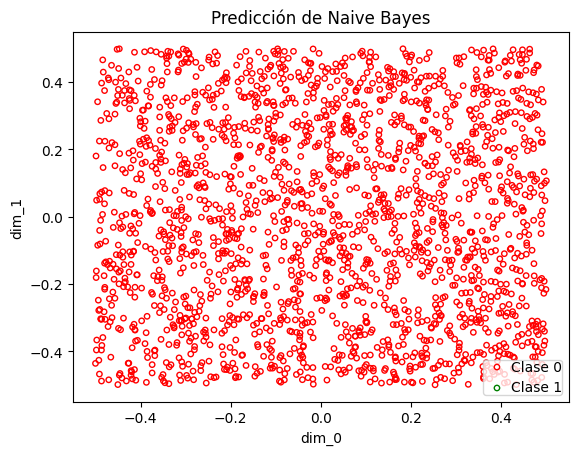

In [56]:
prediction = naive_bayes.predict(X_test)
test_error = zero_one_loss(y_test, prediction)

print(f"Error de Naive Bayes fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes')
plt.show()

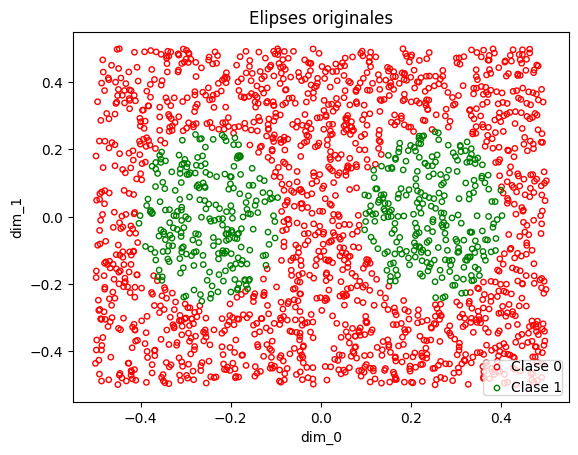

In [57]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Elipses originales')
plt.show()

### Análisis

Claramente en este problema este clasificador no funciona debido a que el mismo asume que las variables siguen una distribucion gaussiana y no es el casos de las elipses, por lo que la predicción es completamente erronea. Para disitintos entrenamientos algunas veces clasifica una zona en el centro como la clase 1 y otras veces simplemente clasifica todo como la clase 0. 

En el caso de este entrenamiento vemos que el clasificador no clasificó ningun punto como clase 1 clasficando todos los puntos de la elipse mal, mientras que la red obtuvo un error menor al 2% ya que no tiene un bias a buscar gaussianas.

## Espirales anidadas

### Entrenamiento

In [36]:
#defino parámetros de la red
epocas_por_entrenamiento=100     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 500
N2=20

In [37]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\488567204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = math.atan2(y, x)
C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\488567204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = math.atan2(y, x)


In [38]:
clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

In [39]:
# Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(train_data, train_target)

GaussianNB()

### Gráficas

Error de ANN fue 0.31399999999999995


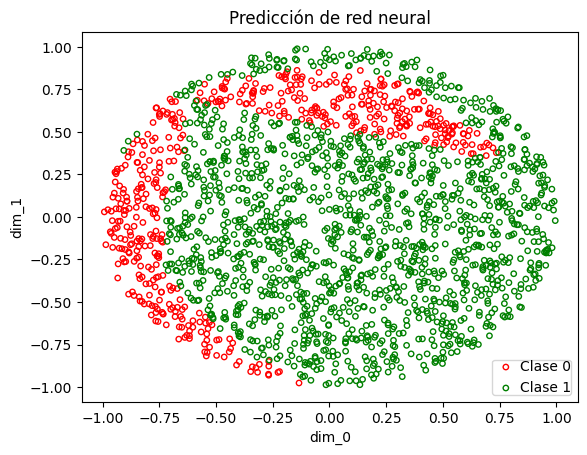

In [40]:
prediction = best_red.predict(X_test)
test_error = zero_one_loss(y_test, prediction)
print(f"Error de ANN fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de red neural')
plt.show()

Error de Naive Bayes fue 0.4285


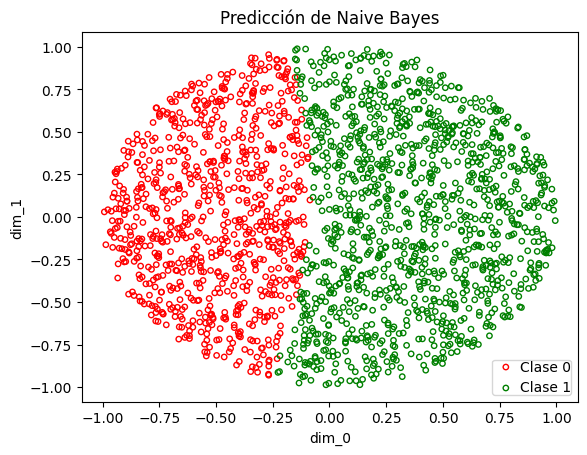

In [41]:
prediction = naive_bayes.predict(X_test)
test_error = zero_one_loss(y_test, prediction)

print(f"Error de Naive Bayes fue {test_error}")

idx = np.where(prediction == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(prediction == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes')
plt.show()

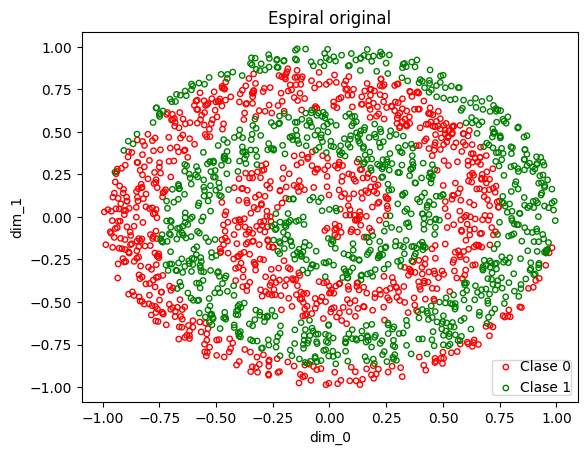

In [42]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

### Análisis

Otra vez podemos ver que el clasificador no funciona para este problema porque este tampoco es una distribución gaussiana, lo único que hace es dividir en dos zonas, muy parecido al resultado obtenido con la red de 2 neuronas. Esta división que obtiene se debe a que la clase 1 es mas densa del lado derecho del espiral mientras que la clase 0 del izquierdo y al momento de predecir gaussianas el modelo obtiene ese resultado. 

Creo yo que si no se asumiera que son gaussianas y tampoco se asumiera la independencia lineal de las variables se obtendría un resultado mucho mejor.

# Ejercicio C

In [99]:
def entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test):
    best_error = 1.0
    best_clasificador = None
    best_discretizador = None
    error_train = []
    error_test = []
    error_val = []
    for bins in bins_values:
        discretizador = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        
        X_train_discretizado = discretizador.fit_transform(X_train)
        X_val_discretizado = discretizador.transform(X_val)
        X_test_discretizado = discretizador.transform(X_test)

        clasificador = CategoricalNB(min_categories=bins)
        clasificador.fit(X_train_discretizado, y_train)

        P_train = clasificador.predict(X_train_discretizado)
        error_train.append(zero_one_loss(y_train, P_train))

        P_val = clasificador.predict(X_val_discretizado)
        error_val.append(zero_one_loss(y_val, P_val))

        P_test = clasificador.predict(X_test_discretizado)
        error_test.append(zero_one_loss(y_test, P_test))

        if error_val[-1] < best_error:
            best_error = error_val[-1]
            best_clasificador = copy.deepcopy(clasificador)
            best_discretizador = copy.deepcopy(discretizador)

    return best_clasificador, best_discretizador, error_train, error_val, error_test

# Ejercicio D

## Dos elipses

### Entrenamiento

In [115]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [116]:
bins_values = range(2, 100)

best_clasificador, best_discretizador, error_train, error_val, error_test = entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test)

### Gráficas

Error de Naive bayes con 18 bins fue 0.044499999999999984


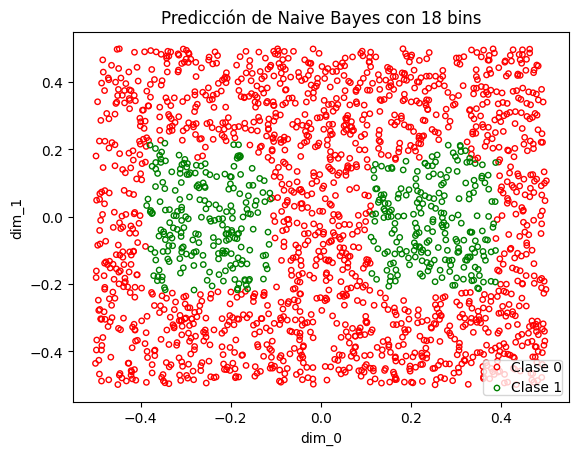

In [117]:
P_test = best_clasificador.predict(best_discretizador.transform(X_test))

test_error = zero_one_loss(y_test, P_test)
print(f"Error de Naive bayes con {best_discretizador.n_bins} bins fue {test_error}")

idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes con {best_discretizador.n_bins} bins')
plt.show()

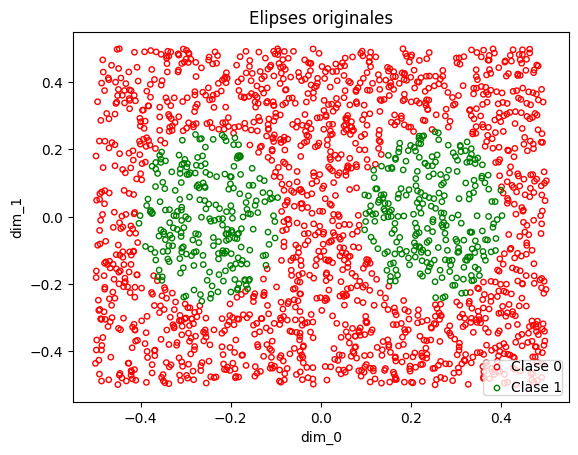

In [118]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Elipses originales')
plt.show()

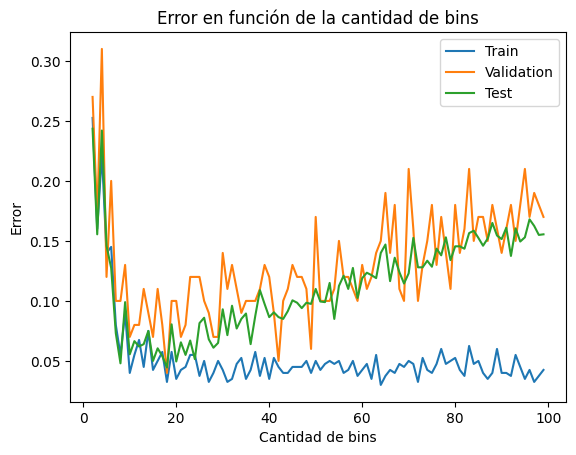

In [119]:
plt.plot(bins_values, error_train, label="Train")
plt.plot(bins_values, error_val, label="Validation")
plt.plot(bins_values, error_test, label="Test")
plt.xlabel("Cantidad de bins")
plt.ylabel("Error")
plt.legend()
plt.title(f'Error en función de la cantidad de bins')
plt.show()

### Análisis
Podemos ver que se obtubo un resultado mucho mejor que con el GaussianNB, incluso llegando a valores de errores menores a 5% con cantidad de bins entre 10 y 20. Esto se logro gracias a la discretización y usar el clasificador CategoricalNB, donde se deja de asumir que las variables siguen una distribución gaussiana para asumir una distribución categorica entre las discretizaciones.

El error baja hasta llegar a 20 bins, luego de eso podemos ver que el error de entrenamiento se mantiene bajo mientras que el error de validación y test suben por lo que hay sobreajuste. Probablemente si usaramos mas puntos para el entrenamiento podriamos crear mas bins para dividir los límites entre los datos de distintas clases y obtener un mejor resultado.

## Espirales anidadas

### Entrenamiento

In [110]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\488567204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = math.atan2(y, x)
C:\Users\lauta\AppData\Local\Temp\ipykernel_7396\488567204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = math.atan2(y, x)


In [111]:
bins_values = range(2, 100)
best_clasificador, best_discretizador, error_train, error_val, error_test = entrenar_naive_bayes_histograma(bins_values, X_train, y_train, X_val, y_val, X_test, y_test)

### Gráficas

Error de Naive Bayes fue 0.3075


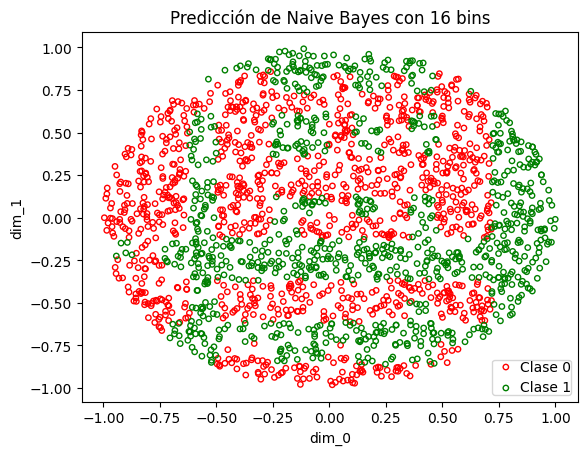

In [112]:
P_test = best_clasificador.predict(best_discretizador.transform(X_test))

test_error = zero_one_loss(y_test, P_test)

print(f"Error de Naive Bayes fue {test_error}")

idx = np.where(P_test == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(P_test == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Predicción de Naive Bayes con {best_discretizador.n_bins} bins')
plt.show()

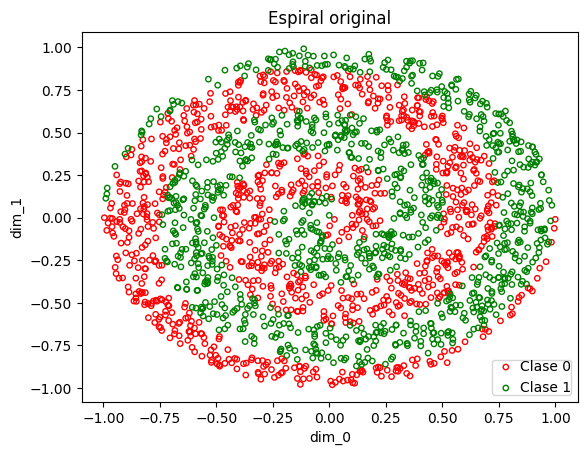

In [113]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test[idx, 0],
    X_test[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

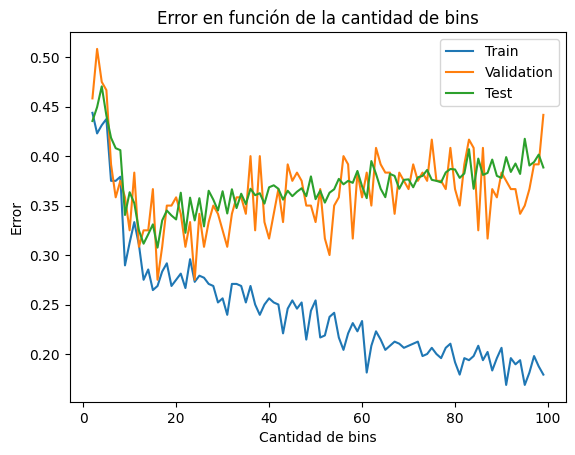

In [114]:
plt.plot(bins_values, error_train, label="Train")
plt.plot(bins_values, error_val, label="Validation")
plt.plot(bins_values, error_test, label="Test")
plt.xlabel("Cantidad de bins")
plt.ylabel("Error")
plt.legend()
plt.title(f'Error en función de la cantidad de bins')
plt.show()

### Análisis
Con este problema obtenemos un error del 30%, bastante mejor que el obtenido con GaussianNB. En la predicción podemos ver muchas fronteras cuadradas producidas por la discretización. El error baja hasta llegar a 20 bins, luego vemos overfitting al igual que en el problema de las elipses.

De todas formas tenemos un error muy alto por lo que no lo considero un buen método para este problema.

# Ejercicio E

In [8]:
X, y = fetch_20newsgroups(subset="train",return_X_y=True, remove=["headers"])
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
X_test, y_test = fetch_20newsgroups(subset="test",return_X_y=True,remove=["headers"])

In [10]:
lengths = [1000, 2000, 3000, 4000, 6000, 8000, 10000, 12000, 14000]
alfas = [1, 0.1, 0.01, 0.001, 0.0001]

best_vectorizador = None
best_clasificador = None
best_error_val = 1.0

errors = {}
for largo_diccionario in lengths:
    vec = CountVectorizer(stop_words='english',max_features=largo_diccionario)
    Xvec_train = vec.fit_transform(X_train).toarray()
    Xvec_val = vec.transform(X_val).toarray()
    Xvec_test = vec.transform(X_test).toarray()
    for alfa in alfas:
        clf = MultinomialNB(alpha=alfa)

        clf.fit(Xvec_train, y_train)

        P_train = clf.predict(Xvec_train)
        error_train = zero_one_loss(y_train, P_train)

        P_val = clf.predict(Xvec_val)
        error_val = zero_one_loss(y_val, P_val)

        P_test = clf.predict(Xvec_test)
        error_test = zero_one_loss(y_test, P_test)

        errors[(largo_diccionario, alfa)] = {'error_train': error_train, 'error_val': error_val, 'error_test': error_test}
        if error_val < best_error_val:
            best_error_val = error_val
            best_vectorizador = copy.deepcopy(vec)
            best_clasificador = copy.deepcopy(clf)

In [ ]:
data = {'Alfa': [], 'Largo Diccionario': [], 'Error Train': [], 'Error Validacion': [], 'Error Test': []}

for ld in lengths:
    for alfa in alfas:
        data['Alfa'].append(alfa)
        data['Largo Diccionario'].append(ld)
        data['Error Train'].append(errors[(ld, alfa)]['error_train'])
        data['Error Validacion'].append(errors[(ld, alfa)]['error_val'])
        data['Error Test'].append(errors[(ld, alfa)]['error_test'])

df = pd.DataFrame(data)
print(df)

      Alfa  Largo Diccionario  Error Train  Error Validacion  Error Test
0   1.0000               1000     0.277431          0.353835    0.413436
1   0.1000               1000     0.267295          0.346059    0.408789
2   0.0100               1000     0.263642          0.346766    0.407329
3   0.0010               1000     0.261874          0.346766    0.410913
4   0.0001               1000     0.260577          0.349947    0.413436
5   1.0000               2000     0.204950          0.284906    0.344928
6   0.1000               2000     0.190572          0.282785    0.341476
7   0.0100               2000     0.183736          0.285967    0.346389
8   0.0010               2000     0.178786          0.287734    0.353824
9   0.0001               2000     0.176547          0.293743    0.360595
10  1.0000               3000     0.172304          0.253446    0.314657
11  0.1000               3000     0.154979          0.252386    0.315985
12  0.0100               3000     0.144137         

In [27]:
Xvec_val = best_vectorizador.transform(X_val).toarray()
Xvec_test = best_vectorizador.transform(X_test).toarray()

P_val = best_clasificador.predict(Xvec_val)
error_val = zero_one_loss(y_val, P_val)

P_test = best_clasificador.predict(Xvec_test)
error_test = zero_one_loss(y_test, P_test)

print(f"El mejor error de validación fue {error_val} con un error de test de {error_test}")
print(f"El mejor largo de diccionario fue {best_vectorizador.max_features} y el mejor alfa fue {best_clasificador.alpha}")

El mejor error de validación fue 0.17285259809119835 con un error de test de 0.2555762081784386
El mejor largo de diccionario fue 14000 y el mejor alfa fue 0.01


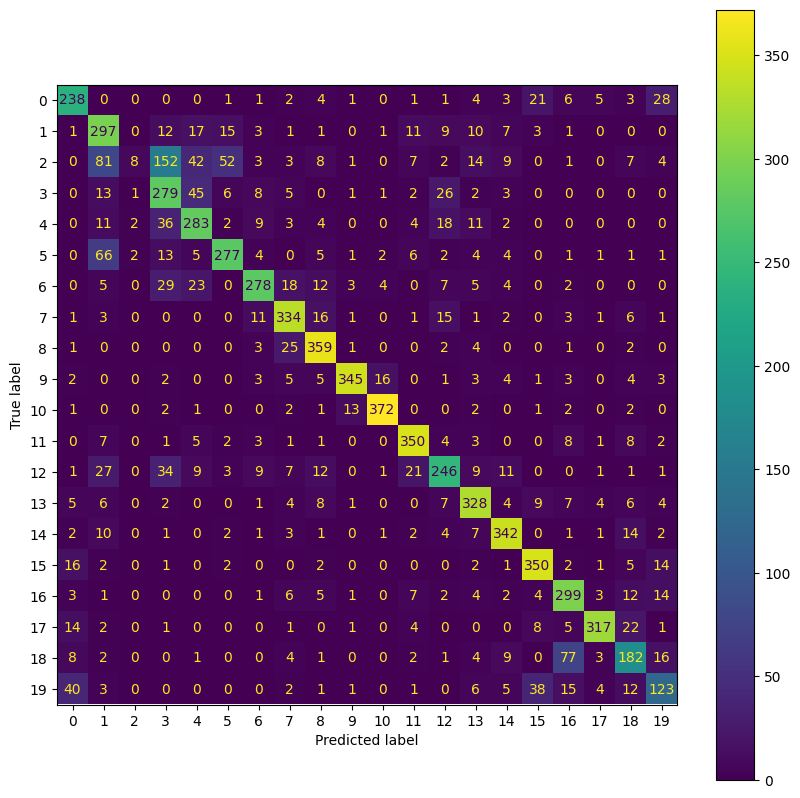

In [28]:
matriz = confusion_matrix(y_test, P_test, labels=best_clasificador.classes_)

cm_display = ConfusionMatrixDisplay(confusion_matrix = matriz, display_labels = best_clasificador.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.show()

### Análisis

Decidí utilizar mas valores para probar el largo del diccionario y el resultado fue que este parámetro no produce sobreajuste, obteniendo el mejor resultado con un largo de 14000 y hasta se podría mejorar con tamaños mas altos, de todas formas las mejoras despues de un largo de 10000 no es mucha y parece converger cerca de 24%/25%. 

El mejor valor de alfa parece estar entre 1 y 0.01.

El conjunto de validación no lo considero bueno ya que cuando utilizamos el tamaño de diccionario de 14000, si bien el mejor error de validación fue el obtenido con alfa de 0.01, para el error de test fue el de alfa igual 1, obteniedo casi un 1% menos de error.

Con respecto a la matriz de confusión podemos ver que en general el resultado fue bueno con la mayoria de las clases sacando algunos casos particulares como podrian ser la clase 18 o 19 donde en esta última mas de la mitad de los de los samples fueron mal clasificados. 
Y en particular la peor clasificación se dio para la clase 2, donde casi todos los samples de esta clase fueron mal clasificados, siendo la mayoria clasificados como clase 3 seguidos por clase 1.

# Ejercicio F